# Decentralization Metrics for DAOs

Authors:

**Ari Kimelman: Kimelmanari@gmail.com**

**Jona Weishaupt: weishaupt.jona@gmail.com**

**Priyanshu Yadav: priyanshu.yadav.152@gmail.com**

In [40]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
plt.style.use('default')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
warnings.filterwarnings("ignore")
import duckdb 
 


## Data

Three Datasets:

1) Deployments (DAOs)
2) Proposals 
3) Votes

More information on the data and the columns can be found in the readme of this project.

In [4]:
# Load the data
deploymentsdf = duckdb.from_parquet('data/daos-census_2023-07-20_big/deployments.parquet')
proposalsdf = duckdb.from_parquet('data/daos-census_2023-07-20_big/proposals.parquet')
votesdf = duckdb.from_parquet('data/daos-census_2023-07-20_big/votes.parquet')

In [5]:
duckdb.query("SELECT * FROM deploymentsdf LIMIT 5").df()

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",5986069,58
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",3116713,2
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",1142459,93
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",899961,122


In [6]:
duckdb.query("SELECT * FROM proposalsdf LIMIT 5").df()
#Check for uniqueness in the proposalids across platforms 

,id,deployment_id,platform_proposal_id,author,date,votes_count
0,a1a650e2-1225-5a90-a648-e6eee005cb27,1ff410f5-1c80-53cd-9558-d93d1f6de121,0x9da21802ef6636402d793d907d5e7818dd14ea355e78...,0xbf5cbde7fdf0b5fa09ce61e50ad46632a09312e9,2019-05-18 18:53:03,7
1,7a520e27-71b6-50b5-9ad6-49bfaed6ecb2,1ff410f5-1c80-53cd-9558-d93d1f6de121,0xdf99c4ed271aa7f21b14f52b03e0ed481ecfbff1647b...,0x3496ae334e811a750c86bd3cd69d61db603c5e69,2019-06-24 19:48:42,10
2,593b9989-aa58-5eaa-8979-20003630dc1c,1ff410f5-1c80-53cd-9558-d93d1f6de121,0xdc67e00f7bf1cb385bdb98cbf7a5c4e021ea36ea495d...,0xcaa9c1251dfdad81f4175edbd09ba9d9131aca77,2019-04-11 14:37:31,11
3,6c015507-4011-5c67-b9f4-8ab85dcca302,d3229595-ac4c-55bf-9808-386fc5603bd1,0x36084df2ecab76964d65089e114c0f52c50afd7f6517...,0xab1bfd1aa856ff159b6892886dcb68fe3aa7fe78,2022-02-04 09:34:24,1
4,71f254fa-ff1d-56aa-8ef1-ba5291809b54,1ff410f5-1c80-53cd-9558-d93d1f6de121,0x048ec0093f570c14540b8b81e20bb57473f867e4f18e...,0x867e3df45c4e235ec27635850b708242f70f7831,2019-06-10 13:10:18,19


In [7]:
duckdb.query("SELECT * FROM votesdf LIMIT 5").df()

,id,proposal_id,deployment_id,platform_vote_id,voter,date,choice,weight
0,a8b902cf-c6ee-5803-bcc6-a4263d832520,c3e93130-1eca-5709-9e86-d6ac3a9c1cad,d3229595-ac4c-55bf-9808-386fc5603bd1,0x000682a038b22925343bd5b9e84acb424a9d14884326...,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,2023-03-14 02:47:23,Pass,9.024850e+22
1,444341a1-178e-5e95-8126-6ad1b7899735,70ec51fe-7cbc-5fbe-8ebf-c886ace664ff,d3229595-ac4c-55bf-9808-386fc5603bd1,0x001cde4d98e26191fc34308be3b51ce50d3eb9561b1b...,0xabd238fa6b6042438fbd22e7d398199080b4224c,2022-05-22 02:09:49,Pass,6.835964e+22
2,ec7349f9-4a69-5452-a16b-f253c9497211,a501deb0-2016-565e-bd90-9421bc215682,d3229595-ac4c-55bf-9808-386fc5603bd1,0x001e7617a24d4e379669db1b4be94aa5cdc1b735d492...,0x13a0b42b9c180065510615972858bf41d1972a55,2019-08-02 09:25:38,Pass,3.728463e+20
3,66822a7a-c8ed-5350-97d7-b4fc4281d5fa,23471a1b-4426-5a1d-add1-e0a739714d71,1ff410f5-1c80-53cd-9558-d93d1f6de121,0x00202af217d5d4f46006ee508af4d4a8e40fa0c58ea0...,0xba527d8301178a03a6993ab5a08cab06b975d5ae,2020-01-10 07:31:45,Pass,1.591787e+20
4,12a310f1-f56b-58b1-8601-216bfb0f1c6c,f7f54dfe-22fb-5a78-8523-39728010f525,6b5b7ac3-c21a-5dec-a79f-799b807f3a73,0x00230b335032c2f363d717da48d79d7574b1712580e0...,0xfc898b18a70ce49579f8d79a32e29928c15b4bc8,2020-02-27 10:45:15,Fail,1.957063e+21


In [8]:
#Now that this works, we can choose some of the big DAOs from our DAO dataset and then work with them
#We will use the 5 DAOS with the most prposals
#Get the top 5 DAOs
chosenDAOs = duckdb.query("SELECT * FROM deploymentsdf ORDER BY proposals_count DESC LIMIT 20").df()
#Show the chosenDAOs unique names with proposalcount
duckdb.query("SELECT DISTINCT name, proposals_count FROM chosenDAOs ORDER BY proposals_count DESC").df()


,name,proposals_count
0,DEAD FoundationsDAO,29681
1,PancakeSwap,2744
2,Decentraland,1962
3,xDXdao,1438
4,Index Coop,918
5,dxDAO,918
6,UXDProtocol,916
7,DAOSquare Grants,880
8,None,860
9,gm DAO,730


## DAO Selection and Exploratory Data Analysis

In [44]:
#Choose DAO here
DAO = 'Aave'

#Get the information for the chosen DAO
DAOinfo = duckdb.query("SELECT * FROM deploymentsdf WHERE name = 'Aave'").df()
DAOinfo

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count
0,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367
1,73c10c98-7499-53b1-8643-c15d8b5dc5b7,tally,eip155:1:0xEC568fffba86c094cf06b22134B23074DFE...,Aave,nan,nan,19443,194
2,cff38513-293c-55b1-862f-7b4b4fa29e5f,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,Aave,nan,nan,13084,173


In [10]:
#Change ID here
myDAOs = ['b6c95a58-d36d-5482-9fa0-fffbbed6e20a']
#Change ID down here as well
chosenDAOs = duckdb.query("SELECT * FROM deploymentsdf WHERE id IN ('b6c95a58-d36d-5482-9fa0-fffbbed6e20a')").df()

In [11]:
chosenDAOs

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count
0,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367


In [12]:
#Merge them with the chosenDAOs with their proposals
chosenDAOs_proposals = duckdb.query("SELECT * FROM chosenDAOs JOIN proposalsdf ON chosenDAOs.id = proposalsdf.deployment_id").df()
duckdb.query("SELECT * FROM chosenDAOs_proposals LIMIT 5").df()
#Now merge the chosenDAOs_proposals with the votes
chosenDAOs_proposals_votes = duckdb.query("SELECT * FROM chosenDAOs_proposals JOIN votesdf ON chosenDAOs_proposals.id_1 = votesdf.proposal_id").df()
duckdb.query("SELECT * FROM chosenDAOs_proposals_votes LIMIT 5").df()
#id_1 is proposal_id
#id_2 is vote_id
#date is proposal_date
#date_1 is vote_date

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count,id_1,deployment_id,...,date,votes_count_1,id_2,proposal_id,deployment_id_1,platform_vote_id,voter,date_1,choice,weight
0,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,2023-06-13 13:32:49,2312,fdc608cb-a741-556e-b31f-f561652a5e56,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,0x98cb4a747731dcd6da030f90b8847c77e19b0af49409...,0xAfA39567165c34eaeed43Ee04036A106a18E2f41,2023-06-15 13:44:56,"[0, 0.16490663624144083, 0, 0]",0.0
1,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,2023-06-13 13:32:49,2312,7883e0b2-6e76-567b-901f-cd1d2158ec45,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,0xbab3432e8677db3df4908e33e8affb26d6fd2ff0a2da...,0x5B8aBA8122Ca6159f66854C469B8a213FF4Ea177,2023-06-15 13:44:56,"[0, 0.16077873424229688, 0.01245145169499455, 0]",0.0
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,2023-06-13 13:32:49,2312,1e84c0e4-063a-5a36-9ef9-48e77455ab88,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,0xbaccc356599a61b728496bb1943d9d75a344a77a2848...,0x74052D8dfaE67c9B33d3c24317CB5f5e1eB7176E,2023-06-15 13:44:56,"[0.001500029837589751, 0.18967766624580049, 0, 0]",0.0
3,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,2023-06-13 13:32:49,2312,a785a654-ec7b-5287-a601-2ac3106d745f,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,0xbf16eabef4698f2c013c7317e8fcff4fa78860bef95e...,0xcC5398b74F65F14CD692f8D16b7B5585aa76ABd9,2023-06-15 13:44:56,"[0, 0.16292411438954058, 0, 0]",0.0
4,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,2023-06-13 13:32:49,2312,ae4ff9ed-8c05-5968-840e-56e39938a8cb,91430738-7883-5bb7-adfb-f889b736a7ea,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,0xc4bb2ec87296679633a8773f09bc8fd51bbc7c6012f5...,0xb800411dd9a1cC2297563127354EB1A1878EB5F0,2023-06-15 13:44:56,"[0, 0.15919326176016416, 0, 0]",0.0


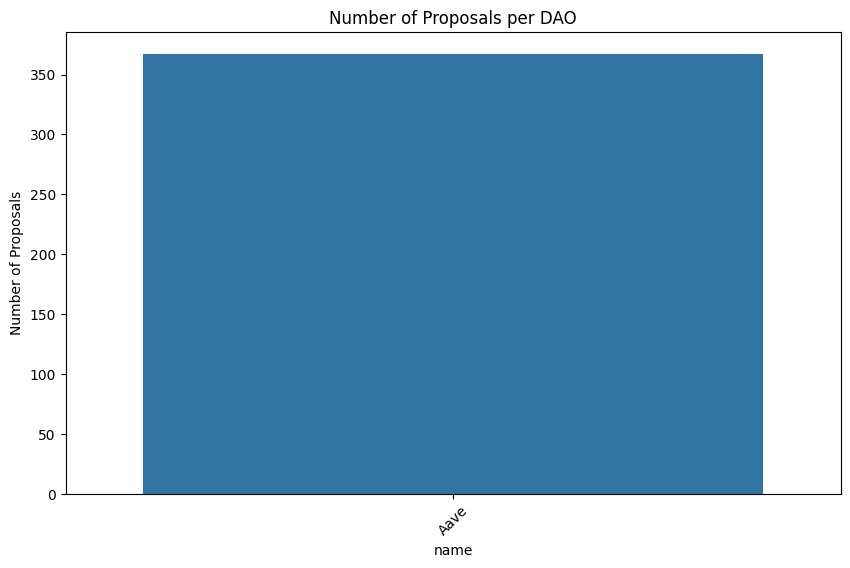

In [13]:
#Do some descriptive statistics and graphs on our chosen DAOs and their proposals

#Get the number of proposals per DAO
proposals_per_dao = chosenDAOs_proposals.groupby('name').size()
proposals_per_dao = proposals_per_dao.reset_index(name='count')
proposals_per_dao = proposals_per_dao.sort_values('count', ascending=False)
proposals_per_dao
#Plot the number of proposals per DAO
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='count', data=proposals_per_dao)
plt.xticks(rotation=45)
plt.ylabel('Number of Proposals')
plt.title('Number of Proposals per DAO')
plt.show()

In [14]:
#Get unique number of voters per DAO
voters_per_dao = chosenDAOs_proposals_votes.groupby('name')['voter'].nunique()	
voters_per_dao = voters_per_dao.reset_index(name='unique_voter_count')
voters_per_dao = voters_per_dao.sort_values('unique_voter_count', ascending=False)
voters_per_dao



,name,unique_voter_count
0,Aave,64715


In [15]:
#Average amount of vote count per proposal
average_votes_per_proposal = chosenDAOs_proposals_votes.groupby('name')['votes_count_1'].mean()
average_votes_per_proposal = average_votes_per_proposal.reset_index(name='average_votes_count')
average_votes_per_proposal = average_votes_per_proposal.sort_values('average_votes_count', ascending=False)
average_votes_per_proposal

,name,average_votes_count
0,Aave,11465.17987


In [16]:
#Number of proposals over time for each DAO per month
chosenDAOs_proposals['date'] = pd.to_datetime(chosenDAOs_proposals['date'])
chosenDAOs_proposals['month'] = chosenDAOs_proposals['date'].dt.to_period('M')
proposals_per_month = chosenDAOs_proposals.groupby(['name', 'month']).size()
proposals_per_month = proposals_per_month.reset_index(name='count')
proposals_per_month = proposals_per_month.sort_values(['name', 'month'])
#Fill NA values with 0
proposals_per_month['count'].fillna(0, inplace=True)
proposals_per_month
#Plot the number of proposals per month for each DAO



,name,month,count
0,Aave,2021-06,1
1,Aave,2021-07,12
2,Aave,2021-08,8
3,Aave,2021-09,9
4,Aave,2021-10,12
5,Aave,2021-11,16
6,Aave,2021-12,6
7,Aave,2022-01,12
8,Aave,2022-02,17
9,Aave,2022-03,4


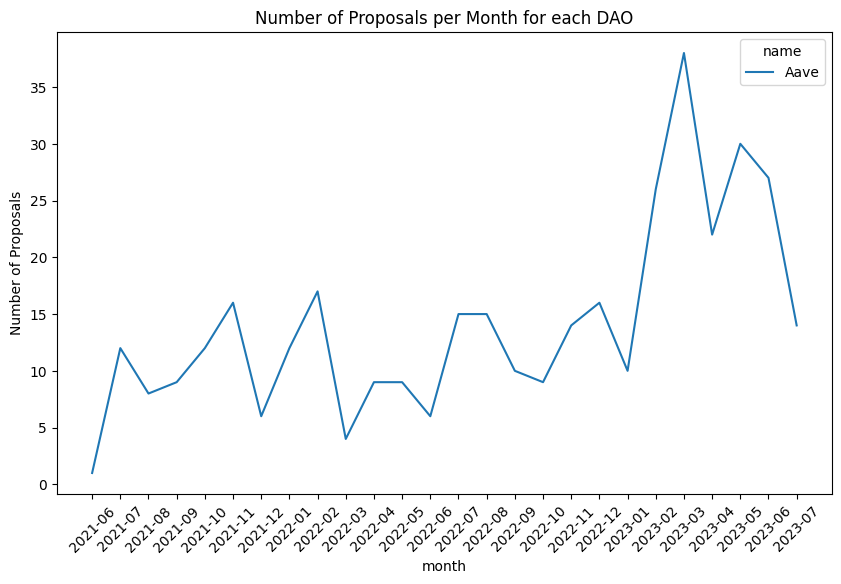

In [17]:
#Change the month to a string
proposals_per_month['month'] = proposals_per_month['month'].astype(str)
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='count', hue='name', data=proposals_per_month)
plt.xticks(rotation=45)
plt.ylabel('Number of Proposals')
plt.title('Number of Proposals per Month for each DAO')
plt.show()

In [18]:
daosDF = chosenDAOs_proposals_votes

print("We currently have a total of ", daosDF.shape[0], " recorded votes in our dataset")
print("With these amount of proposals per DAO: ", daosDF.groupby('name')['id_1'].nunique())


We currently have a total of  2020544  rows in our dataset
With these amount of proposals per DAO:  name
Aave    367
Name: id_1, dtype: int64


### Metric: How much power does the most powerful vote have per proposal?

**Logic:** 

Each singular vote is marked with a weight, which represents the power that vote had on the result. Investigating how much influence the most powerful weight (max weight) had on the outcome in comparison to all other voters is a strong indicator for decentralization. A lower number would therefore represent a more decentralized voting process.

**Metrics Calculated Below**

1) Average power percentage of the max vote
2) Distribution of the most powerful vote over proposals
3) Distribution over time
4) Average power percentage of the max vote over time

In [19]:
#Get the total weight of all votes per proposal using pandas and save as column
daosDF['total_weight'] = daosDF.groupby('proposal_id')['weight'].transform('sum')
#Get the max vote weight per proposal
daosDF['max_weight'] = daosDF.groupby('proposal_id')['weight'].transform('max')
#Get the percentage of of the max on total weight
daosDF['percentage_max'] = daosDF['max_weight'] / daosDF['total_weight']
#Plot the distribution of the percentage of max votes per DAO as color



In [43]:
#Show averages per DAO
onlyProposals = daosDF.drop_duplicates(subset=['proposal_id'])
onlyProposals.groupby('name')['percentage_max'].mean()

name
Aave    0.463625
Name: percentage_max, dtype: float64

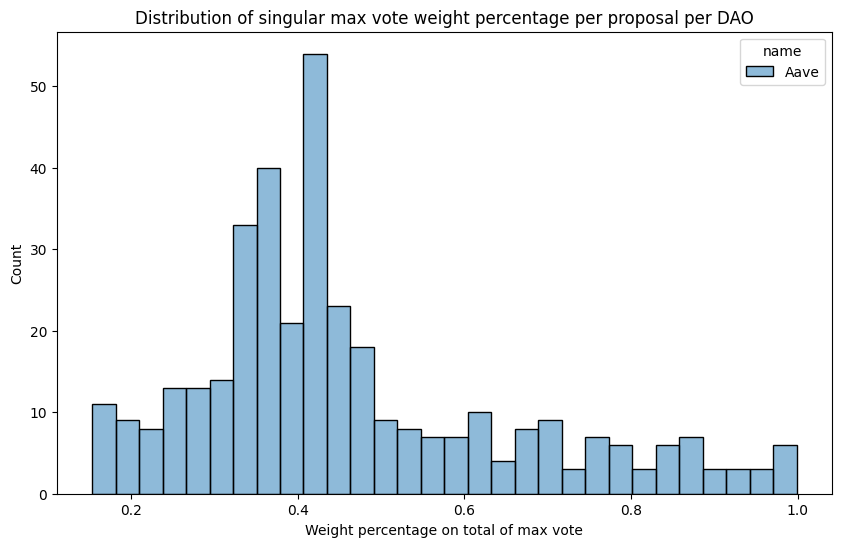

In [20]:
plt.figure(figsize=(10, 6))
plt.title('Distribution of singular max vote weight percentage per proposal per DAO')
sns.histplot(data=onlyProposals, x='percentage_max', hue='name', bins=30)
plt.xlabel('Weight percentage on total of max vote')
plt.ylabel('Count')
plt.show()

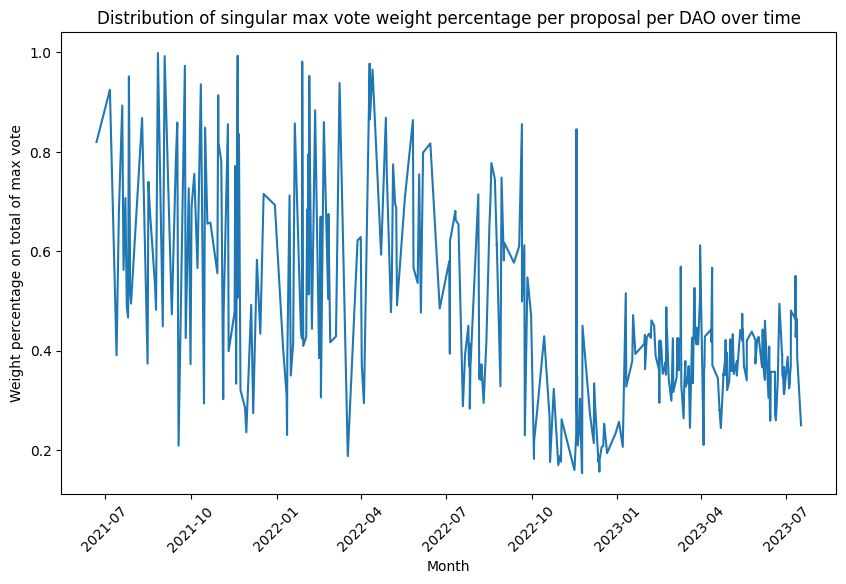

In [21]:
aaveProposals = daosDF[daosDF['name'] == 'Aave']
aaveProposals['date'] = pd.to_datetime(aaveProposals['date'])
aaveProposals['month'] = aaveProposals['date'].dt.to_period('M')
proposals_per_month['month'] = proposals_per_month['month'].astype(str)
aaveProposals = aaveProposals.drop_duplicates(subset=['proposal_id'])
plt.figure(figsize=(10, 6))
plt.title('Distribution of singular max vote weight percentage per proposal per DAO over time')
sns.lineplot(x='date', y='percentage_max', data=aaveProposals)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Weight percentage on total of max vote')
plt.show()

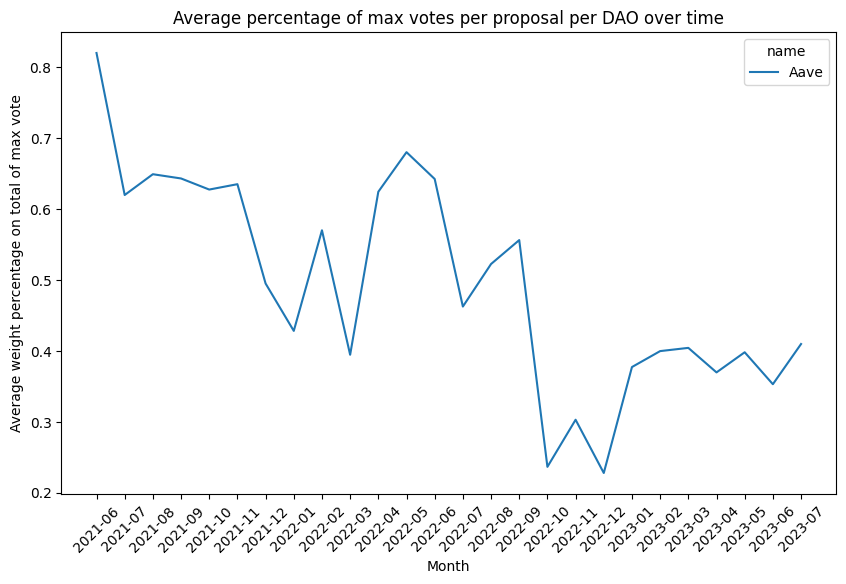

In [22]:
#Plot average percentage of max votes per proposal per DAO per Month
#Create month column
daosDF['date'] = pd.to_datetime(daosDF['date'])
daosDF['month'] = daosDF['date'].dt.to_period('M')
#Get the average percentage of max votes per proposal per DAO per month
average_percentage_max = daosDF.groupby(['name', 'month'])['percentage_max'].mean()
average_percentage_max = average_percentage_max.reset_index()
average_percentage_max['month'] = average_percentage_max['month'].astype(str)
#Filter on Aave, Ribbon, Lido
average_percentage_max = average_percentage_max[average_percentage_max['name'].isin(['Aave'])]
#Plot the average percentage of max votes per proposal per DAO per month
plt.figure(figsize=(10, 6))
plt.title('Average percentage of max votes per proposal per DAO over time')
sns.lineplot(x='month', y='percentage_max', hue='name', data=average_percentage_max)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average weight percentage on total of max vote')
plt.show()


### Metrics: Nakamodo Coefficient

**Logic:**

How much voters are needed, to reach 51% of the voting power in a proposal, which would represent a deciding vote. The higher the number, the more decentralized your DAO would be.

**Metrics Calculated Below**

1) Average Nakamodo Index over proposals
2) Distribution of Nakamodo Indexes over proposals
3) Average Nakamodo Index over time

In [24]:
#Caculate the percentage of the weight of the total weight per row
daosDF['weight_percentage'] = daosDF['weight'] / daosDF['total_weight']
#Get cumulative sum of the weight percentage per proposal

#Sort by descending cumulative weight per proposal
daosDF = daosDF.sort_values(by=['proposal_id', 'weight_percentage'], ascending=[True, False])
daosDF = daosDF.reset_index(drop=True)
#Add a fake date to the dataset that just counts the rows
daosDF['fake_date'] = range(1, len(daosDF) + 1)
daosDF['cumulative_weight'] = daosDF.groupby('proposal_id')['weight_percentage'].cumsum()

#Add column is passed if the cumulative weight is above 0.5
daosDF['is_passed'] = daosDF['cumulative_weight'] > 0.5

#Find first instance of proposal_id where is_passed is True
daosDF['first_passed'] = daosDF.groupby('proposal_id')['is_passed'].transform('idxmax')

#Get the index first index of where a proposal appears
daosDF['first_appeared'] = daosDF.groupby('proposal_id')['fake_date'].transform('idxmin')

#Create column min_51% as the absolute difference between the first passed and first appeared
daosDF['min_51%'] = ((daosDF['first_passed'] - daosDF['first_appeared']).abs()) +1


In [25]:
#Check for one proposal to verfiy calculations
daosDF[daosDF['proposal_id'] == 'ff9694ed-7576-58e1-9b2f-c336cb6f612e']
#As you can see one person has almost 68% of the votes, so the proposal has a Nakamoto coefficient of 1 (noted in min_51%),
#even though 178 people voted, which is a bad sign for decentralization


,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count,id_1,deployment_id,...,max_weight,percentage_max,month,weight_percentage,fake_date,cumulative_weight,is_passed,first_passed,first_appeared,min_51%
2020366,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.682583,2020367,0.682583,True,2020366,2020366,1
2020367,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.184279,2020368,0.866862,True,2020366,2020366,1
2020368,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.027114,2020369,0.893976,True,2020366,2020366,1
2020369,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.024543,2020370,0.918520,True,2020366,2020366,1
2020370,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.021076,2020371,0.939596,True,2020366,2020366,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020539,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.000000,2020540,1.000000,True,2020366,2020366,1
2020540,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.000000,2020541,1.000000,True,2020366,2020366,1
2020541,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.000000,2020542,1.000000,True,2020366,2020366,1
2020542,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367,ff9694ed-7576-58e1-9b2f-c336cb6f612e,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,...,64773.0,0.682583,2021-08,0.000000,2020543,1.000000,True,2020366,2020366,1


In [27]:
#Get the average min_51% per DAO
average_min_51 = daosDF.groupby('name')['min_51%'].mean()
print("The average min_51% per DAO is: " ,average_min_51)


The average min_51% per DAO is:  name
Aave    2.1234
Name: min_51%, dtype: float64


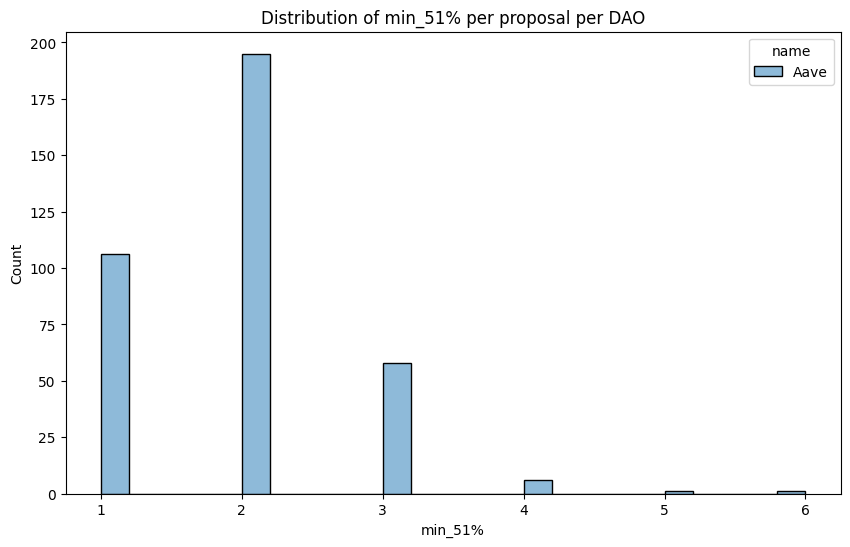

In [42]:
onlyProposals = daosDF.drop_duplicates(subset=['proposal_id'])

#Plot the distribution of the min_51% per DAO as color
plt.figure(figsize=(10, 6))
plt.title('Distribution of min_51% per proposal per DAO')
sns.histplot(data=onlyProposals, x='min_51%', hue='name', bins=25)
plt.xlabel('min_51%')
plt.ylabel('Count')
plt.show()

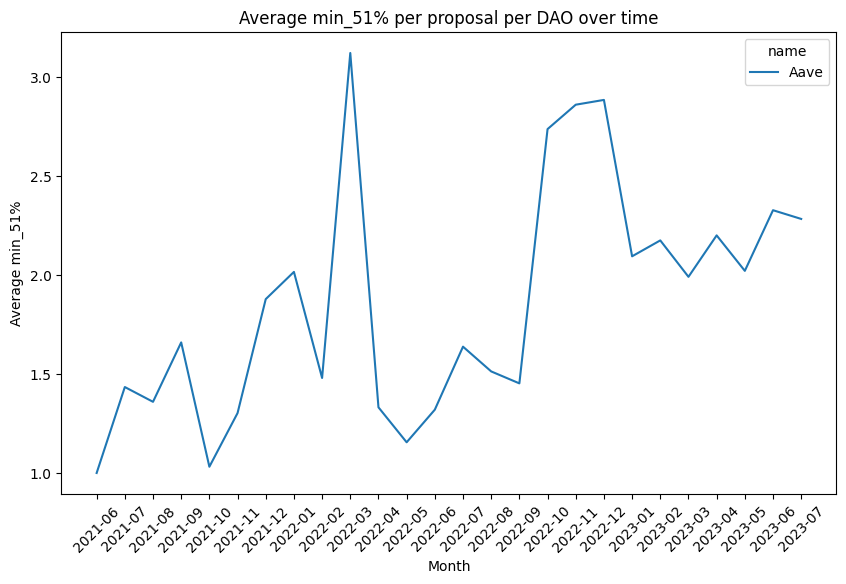

In [28]:
#Plot the average min_51% per DAO per month
average_min_51_month = daosDF.groupby(['name', 'month'])['min_51%'].mean()
average_min_51_month = average_min_51_month.reset_index()
average_min_51_month['month'] = average_min_51_month['month'].astype(str)
#File on Aave, Ribbon, Lido
average_min_51_month = average_min_51_month[average_min_51_month['name'].isin(['Aave'])]
#The end date is 2023-07
plt.figure(figsize=(10, 6))
plt.title('Average min_51% per proposal per DAO over time')
sns.lineplot(x='month', y='min_51%', hue='name', data=average_min_51_month)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average min_51%')
plt.show()

### Metrics: Participation Rate 

**Logic:**

How many of all total possible voters, actually voted on the proposal. A higher rate shows more engagement in the DAOs voting processes.

**Metrics Calculated Below**

1) Average Participaton rate of the DAO in %
2) Distribution of participation rates among proposals
3) Average Participation rate over time

The average participation rate per DAO is:  name
Aave    0.177164
Name: participation_rate, dtype: float64


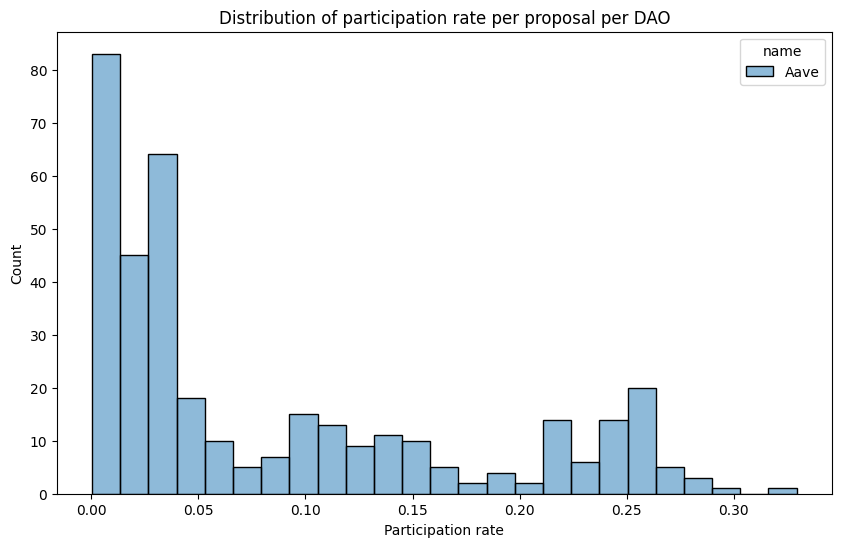

In [29]:
#Get participation rates per DAO
daosDF["total_voters"] = daosDF.groupby('name')['voter'].transform('nunique')
#Participation rate per proposal
daosDF['participation_rate'] = daosDF['voter'].groupby(daosDF['proposal_id']).transform('nunique') / daosDF['total_voters']

#Get the average participation rate per DAO
average_participation_rate = daosDF.groupby('name')['participation_rate'].mean()
print("The average participation rate per DAO is: " ,average_participation_rate)

onlyProposals = daosDF.drop_duplicates(subset=['proposal_id'])
#Plot the distribution of the participation rate per DAO as color
plt.figure(figsize=(10, 6))
plt.title('Distribution of participation rate per proposal per DAO')
sns.histplot(data=onlyProposals, x='participation_rate', hue='name', bins=25)
plt.xlabel('Participation rate')
plt.ylabel('Count')
plt.show()

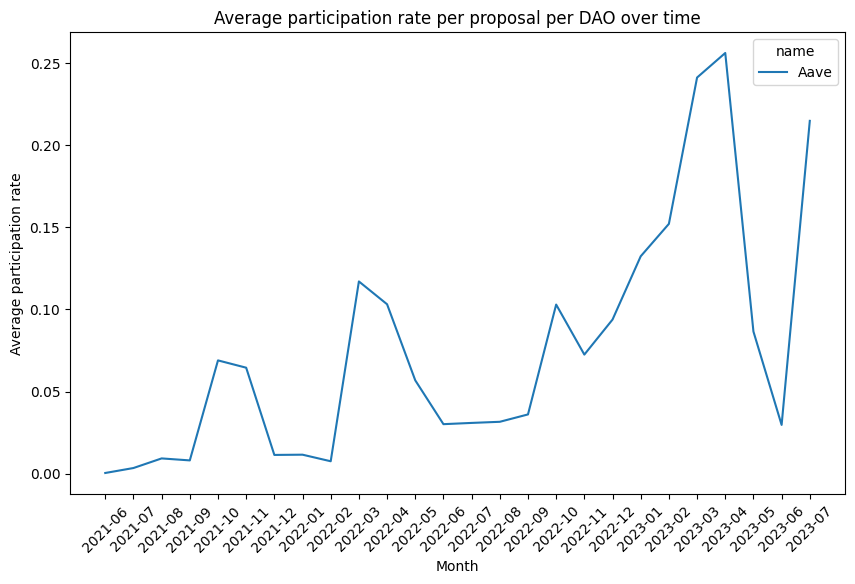

In [30]:
#Plot the rolling-average participation rate per DAO per month
average_participation_rate_month = daosDF.groupby(['name', 'month'])['participation_rate'].mean()
average_participation_rate_month = average_participation_rate_month.reset_index()
average_participation_rate_month['month'] = average_participation_rate_month['month'].astype(str)
#Filter on Aave, Ribbon, Lido
average_participation_rate_month = average_participation_rate_month[average_participation_rate_month['name'].isin(['Aave'])]
#The end date is 2023-07
plt.figure(figsize=(10, 6))
plt.title('Average participation rate per proposal per DAO over time')
sns.lineplot(x='month', y='participation_rate', hue='name', data=average_participation_rate_month)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average participation rate')
plt.show()


### Metrics: Gini Coefficient

**Logic**

The gini coefficient is a universal measure for inequality in all types of contexts, most typically used to measure wealth distribution in countries. In the context of DAOs, the gini coefficient can be used to measure how equal or unequal tokens are distributed, or in this case how equal or unequal voting power is distributed among users.

**Metrics Calculated Below**

1) Gini Coefficient: 0-1 (0 meaning total equality and 1 total inequality)
2) Gini Coefficient over 3 month periods: 0-1 (0 meaning total equality and 1 total inequality)
3) Gini Coefficient over 3 month periods with rolling average:(0 meaning total equality and 1 total inequality)
4) Gini Coefficient compared with number of proposals in that period

In [33]:

def calculate_gini_coefficient(values):
    # Sort values in ascending order
    sorted_values = np.sort(values)
    
    # Calculate cumulative shares of the variable and population
    n = len(sorted_values)
    cumulative_variable = np.cumsum(sorted_values)
    cumulative_population = np.arange(1, n + 1)  # 1-based index
    
    # Calculate Lorenz curve coordinates
    lorenz_curve_x = cumulative_population / n
    lorenz_curve_y = cumulative_variable / cumulative_variable[-1]  # Normalize to total sum
    
    # Calculate area under the Lorenz curve using trapezoidal rule
    area_under_lorenz_curve = np.trapz(lorenz_curve_y, lorenz_curve_x)
    
    # Calculate Gini coefficient
    G = 1 - 2 * area_under_lorenz_curve
    
    return G

def calculate_gini_coefficient_by_bank(df):
    # Group by bank name and calculate Gini coefficient for each bank
    gini_coefficients = df.groupby('name')['weight'].apply(calculate_gini_coefficient)
    
    return gini_coefficients


bank_gini_coefficients = calculate_gini_coefficient_by_bank(daosDF)

# Print Gini coefficients for each bank
for bank, gini_coefficient in bank_gini_coefficients.items():
    print(f"Gini coefficient for {bank}: {gini_coefficient:.4f}")


Gini coefficient for Aave: 0.9994


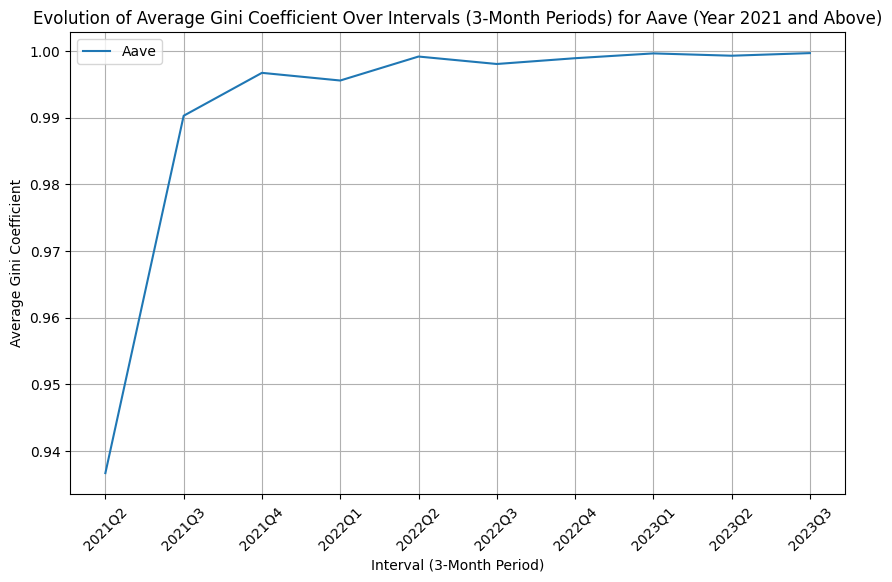

In [32]:
def calculate_gini_coefficient(values):
    # Sort values in ascending order
    sorted_values = np.sort(values)
    
    # Calculate cumulative shares of the variable and population
    n = len(sorted_values)
    cumulative_variable = np.cumsum(sorted_values)
    cumulative_population = np.arange(1, n + 1)  # 1-based index
    
    # Calculate Lorenz curve coordinates
    lorenz_curve_x = cumulative_population / n
    lorenz_curve_y = cumulative_variable / cumulative_variable[-1]  # Normalize to total sum
    
    # Calculate area under the Lorenz curve using trapezoidal rule
    area_under_lorenz_curve = np.trapz(lorenz_curve_y, lorenz_curve_x)
    
    # Calculate Gini coefficient
    G = 1 - 2 * area_under_lorenz_curve
    
    return G

def calculate_gini_coefficient_by_interval(df):
    # Calculate Gini coefficient for each proposal
    df['gini_coefficient'] = df.groupby('proposal_id')['weight'].transform(calculate_gini_coefficient)
    
    # Filter dates from year 2021 and onwards
    # filtered_df = df[df['date'].dt.year >= 2021]
    
    # Create a new column for 3-month intervals
    df['interval'] = pd.to_datetime(df['date']).dt.to_period('Q')
    
    # Group by interval and name and calculate mean Gini coefficient
    interval_gini_coefficients = (
        df.groupby(['interval', 'name'])
        .agg({'gini_coefficient': 'mean'})
        .reset_index()
    )
    
    return interval_gini_coefficients

# Example usage:
# Assuming 'top5DAOs_proposals_votes' is your DataFrame containing the required columns

# Calculate Gini coefficients by interval (every 3 months) for dates from year 2021 and onwards
interval_gini_coefficients = calculate_gini_coefficient_by_interval(daosDF)

# Get unique DAO names
dao_names = interval_gini_coefficients['name'].unique()

# Plot a separate graph for each DAO
for dao_name in dao_names:
    # Filter data for the current DAO
    dao_data = interval_gini_coefficients[interval_gini_coefficients['name'] == dao_name]
    
    # Create a new figure and axis for the current DAO
    plt.figure(figsize=(10, 6))
    
    # Plot the evolution of average Gini coefficient over intervals for the current DAO
    plt.plot(dao_data['interval'].astype(str), dao_data['gini_coefficient'], label=dao_name)
    
    plt.xlabel('Interval (3-Month Period)')
    plt.ylabel('Average Gini Coefficient')
    plt.title(f'Evolution of Average Gini Coefficient Over Intervals (3-Month Periods) for {dao_name} (Year 2021 and Above)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Show or save the plot for the current DAO
    # You can save each plot to a file using plt.savefig() if needed
    plt.show()  # Show the plot for the current DAO

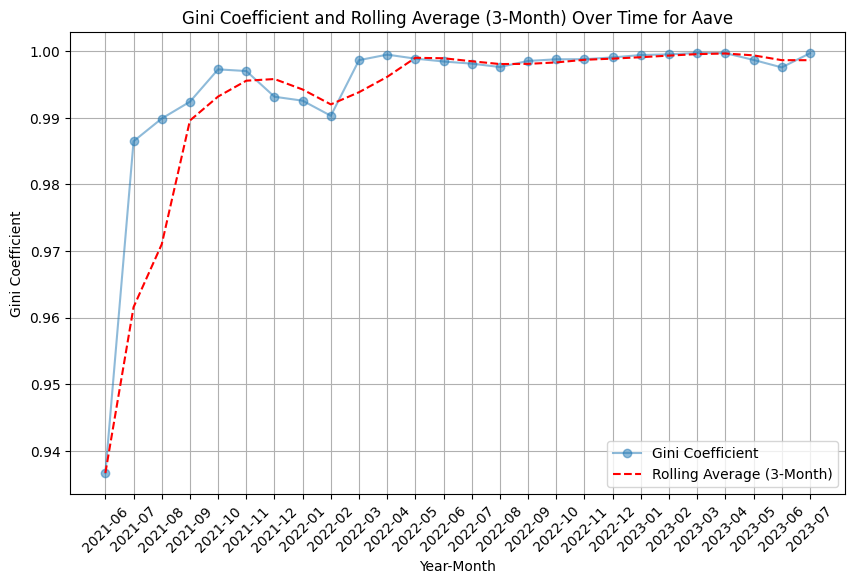

In [36]:
def calculate_gini_coefficient(values):
    # Sort values in ascending order
    sorted_values = np.sort(values)
    
    # Calculate cumulative shares of the variable and population
    n = len(sorted_values)
    cumulative_variable = np.cumsum(sorted_values)
    cumulative_population = np.arange(1, n + 1)  # 1-based index
    
    # Calculate Lorenz curve coordinates
    lorenz_curve_x = cumulative_population / n
    lorenz_curve_y = cumulative_variable / cumulative_variable[-1]  # Normalize to total sum
    
    # Calculate area under the Lorenz curve using trapezoidal rule
    area_under_lorenz_curve = np.trapz(lorenz_curve_y, lorenz_curve_x)
    
    # Calculate Gini coefficient
    G = 1 - 2 * area_under_lorenz_curve
    
    return G

def calculate_gini_and_rolling_average(df):
    # Calculate Gini coefficient for each proposal
    df['gini_coefficient'] = df.groupby('proposal_id')['weight'].transform(calculate_gini_coefficient)
    
    # Convert 'date' column to datetime format and extract month and year
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')  # Group by year-month
    
    # Calculate Gini coefficient for each month
    monthly_gini_data = (
        df.groupby(['name', 'year_month'])['gini_coefficient']
        .mean()
        .reset_index()
    )
    
    # Calculate rolling average of Gini coefficient for each DAO
    monthly_gini_data['rolling_avg_gini'] = (
        monthly_gini_data.groupby('name')['gini_coefficient']
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())  # 3-month rolling average
    )
    
    return monthly_gini_data

# Assuming 'top5DAOs_proposals_votes' is your DataFrame containing 'name', 'weight', 'date', and 'proposal_id' columns

# Calculate monthly Gini coefficient and rolling average for each DAO
monthly_gini_data = calculate_gini_and_rolling_average(daosDF)

# Get unique DAO names
dao_names = monthly_gini_data['name'].unique()

# Create separate plots for rolling average of Gini coefficient for each DAO
for dao in dao_names:
    dao_data = monthly_gini_data[monthly_gini_data['name'] == dao]
    months = dao_data['year_month'].astype(str)  # Convert Periods to string for plotting
    gini_coefficient = dao_data['gini_coefficient']
    rolling_avg_gini = dao_data['rolling_avg_gini']
    
    # Plot original Gini coefficient and rolling average
    plt.figure(figsize=(10, 6))
    plt.plot(months, gini_coefficient, label='Gini Coefficient', linestyle='-', marker='o', alpha=0.5)
    plt.plot(months, rolling_avg_gini, label='Rolling Average (3-Month)', linestyle='--', color='red')
    
    plt.xlabel('Year-Month')
    plt.ylabel('Gini Coefficient')
    plt.title(f'Gini Coefficient and Rolling Average (3-Month) Over Time for {dao}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Save or display the plot for the current DAO
    # Modify the file path or method of displaying the plot as needed
    plt.savefig(f'{dao}_rolling_average_plot.png')  # Save plot as image file
    plt.show()  # Display plot

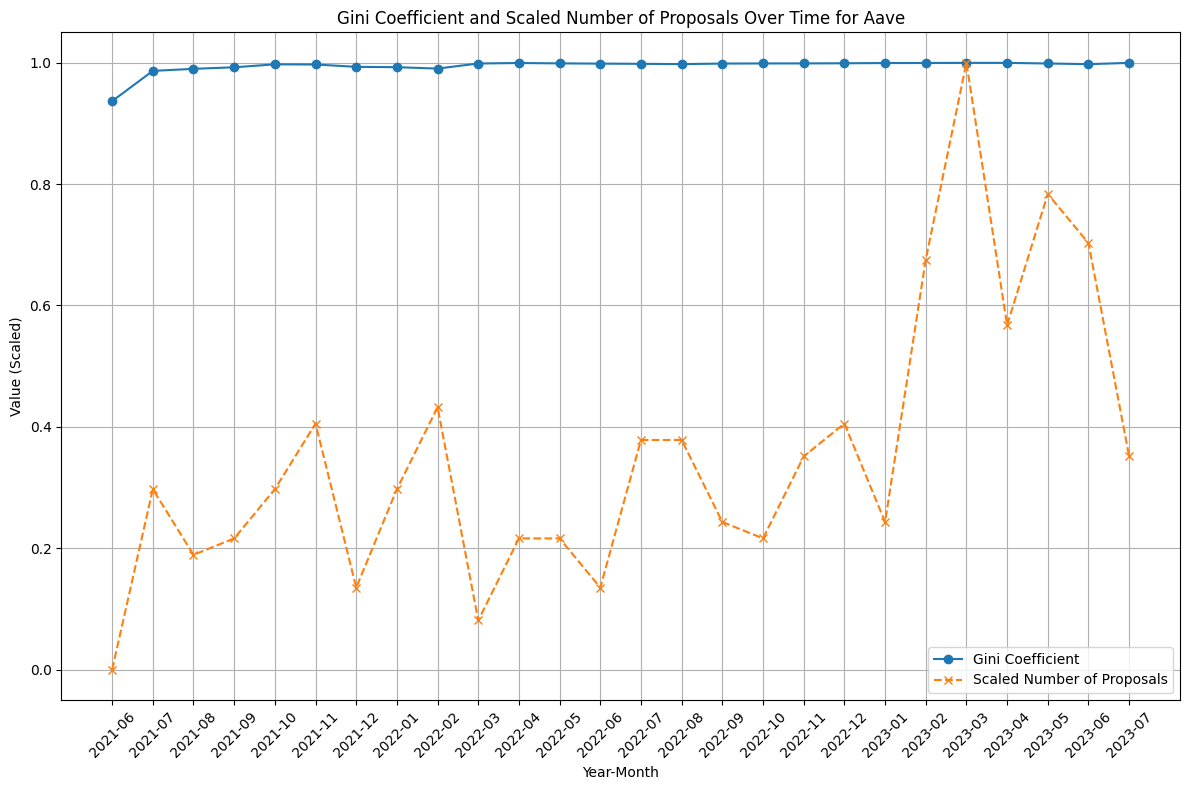

In [41]:
def calculate_gini_coefficient(values):
    # Sort values in ascending order
    sorted_values = np.sort(values)
    
    # Calculate cumulative shares of the variable and population
    n = len(sorted_values)
    cumulative_variable = np.cumsum(sorted_values)
    cumulative_population = np.arange(1, n + 1)  # 1-based index
    
    # Calculate Lorenz curve coordinates
    lorenz_curve_x = cumulative_population / n
    lorenz_curve_y = cumulative_variable / cumulative_variable[-1]  # Normalize to total sum
    
    # Calculate area under the Lorenz curve using trapezoidal rule
    area_under_lorenz_curve = np.trapz(lorenz_curve_y, lorenz_curve_x)
    
    # Calculate Gini coefficient
    G = 1 - 2 * area_under_lorenz_curve
    
    return G

def calculate_gini_and_proposals(df):
    # Convert 'date' column to datetime format and extract year-month
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')
    
    # Calculate Gini coefficient for each proposal
    df['gini_coefficient'] = df.groupby(['year_month', 'proposal_id'])['weight'].transform(calculate_gini_coefficient)
    
    # Group by DAO name ('name') and year-month ('year_month')
    dao_monthly_data = df.groupby(['name', 'year_month']).agg({
        'gini_coefficient': 'mean',  # Calculate mean Gini coefficient for each month
        'proposal_id': 'nunique'  # Count number of unique proposals for each month
    }).reset_index()
    
    # Scale the number of proposals to range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    dao_monthly_data['scaled_proposals'] = scaler.fit_transform(dao_monthly_data[['proposal_id']])
    
    return dao_monthly_data

# Assuming 'top5DAOs_proposals_votes' is your DataFrame containing 'name', 'proposal_id', 'weight', and 'date' columns

# Calculate Gini coefficient and number of proposals for each DAO
dao_monthly_data = calculate_gini_and_proposals(daosDF)

# Get unique DAO names
dao_names = dao_monthly_data['name'].unique()

# Plotting Gini coefficient and scaled number of proposals for each DAO
for dao in dao_names:
    dao_data = dao_monthly_data[dao_monthly_data['name'] == dao]
    months = dao_data['year_month'].astype(str)
    gini_coefficient = dao_data['gini_coefficient']
    scaled_proposals = dao_data['scaled_proposals']
    
    # Create a new figure for each DAO
    plt.figure(figsize=(12, 8))
    
    # Plot Gini coefficient and scaled number of proposals
    plt.plot(months, gini_coefficient, label='Gini Coefficient', linestyle='-', marker='o')
    plt.plot(months, scaled_proposals, label='Scaled Number of Proposals', linestyle='--', marker='x')
    
    plt.xlabel('Year-Month')
    plt.ylabel('Value (Scaled)')
    plt.title(f'Gini Coefficient and Scaled Number of Proposals Over Time for {dao}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Show plot for the current DAO
    plt.show()